In [ ]:
!pip install bertopic umap-learn sentence-transformers
!pip install streamlit --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install google-play-scraper

from google_play_scraper import reviews, Sort
import pandas as pd

apps = {
    "PayPal": "com.paypal.android.p2pmobile",
    "GPay": "com.google.android.apps.nbu.paisa.user",
    "PhonePe": "com.phonepe.app"
}

def fetch_reviews(app_name, app_id, count=5000):
    all_reviews = []
    token = None
    while len(all_reviews) < count:
        new_reviews, token = reviews(
            app_id,
            lang='en',
            country='us',
            sort=Sort.NEWEST,
            count=200,
            continuation_token=token
        )
        all_reviews += new_reviews
        if token is None:
            break
    df = pd.DataFrame(all_reviews)
    df["app_name"] = app_name
    return df

# Combine all 3 apps
dfs = []
for name, pkg in apps.items():
    print(f"Fetching {name}...")
    dfs.append(fetch_reviews(name, pkg))

all_reviews = pd.concat(dfs, ignore_index=True)
print(f" Scraped {len(all_reviews)} total reviews")






     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
Fetching PayPal...
Fetching GPay...
Fetching PhonePe...
 Scraped 15000 total reviews


In [ ]:
import re

# Safe text cleaner
def clean_review_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'[^\x00-\x7F]+', '', text)              # remove emojis
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)         # remove symbols
    text = re.sub(r'\s+', ' ', text).strip()               # remove extra whitespace
    return text

# Apply cleaner safely
all_reviews["cleaned_content"] = all_reviews["content"].apply(clean_review_text)
all_reviews = all_reviews[all_reviews["cleaned_content"].str.len() >= 15]
all_reviews = all_reviews.drop_duplicates(subset="cleaned_content")
all_reviews["review_length"] = all_reviews["cleaned_content"].apply(len)

# Issue classification (fraud/usability/positive)
def classify_issue(text):
    text = text.lower()
    if any(word in text for word in ["fraud", "unauthorized", "hacked", "money got deducted", "stolen"]):
        return "Fraud"
    elif any(word in text for word in ["slow", "buggy", "crash", "otp", "login", "error", "ui"]):
        return "Usability"
    else:
        return "Positive"

all_reviews["issue_type"] = all_reviews["cleaned_content"].apply(classify_issue)

# Fake review detector
def detect_fake_review(row):
    text = row['cleaned_content']
    score = row['score']
    if text.isupper():
        return True
    if len(set(text.lower().split())) <= 3:
        return True
    if text.count('!') > 5:
        return True
    if score == 5 and len(text) < 20:
        return True
    return False

all_reviews["is_fake"] = all_reviews.apply(detect_fake_review, axis=1)
cleaned_reviews = all_reviews[all_reviews["is_fake"] == False]


In [ ]:
!pip install bertopic[visualization] sentence-transformers umap-learn

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

texts = cleaned_reviews["cleaned_content"].dropna().tolist()
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts, embeddings)

topic_model.get_topic_info().head()



/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Topic  Count                         Name  \
0     -1   1627              -1_to_my_the_it   
1      0    510         0_app_very_this_good   
2      1    398         1_paypal_they_and_my   
3      2    262            2_hai_ho_raha_bhi   
4      3    146  3_easy_use_quick_convenient   

                                      Representation  \
0  [to, my, the, it, and, for, money, account, is...   
1  [app, very, this, good, nice, useful, best, ea...   
2  [paypal, they, and, my, you, with, me, to, of,...   
3  [hai, ho, raha, bhi, nhi, se, nahi, ka, na, ba...   
4  [easy, use, quick, convenient, very, fast, hel...   

                                 Representative_Docs  
0  [No one should download this. They will occasi...  
1  [This app is very good, this is a very good ap...  
2  [you cant go wrong with PayPal, they will back...  
3  [app open nhi ho raha hai, dffgvccccfgff chall...  
4  [quick. very easy to use, easy and good to use...

In [ ]:
import re

#  Clean review content (remove emojis, special chars, extra spaces)
def clean_review_text(text):
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove emojis/non-ASCII
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

all_reviews["cleaned_content"] = all_reviews["content"].apply(clean_review_text)

#  Remove very short reviews and duplicates
all_reviews = all_reviews[all_reviews["cleaned_content"].str.len() >= 15]
all_reviews = all_reviews.drop_duplicates(subset="cleaned_content")

# Add length feature
all_reviews["review_length"] = all_reviews["cleaned_content"].apply(len)

#  Classify issues: Fraud / Usability / Positive
def classify_issue(text):
    text = text.lower()
    if any(w in text for w in ["fraud", "unauthorized", "hacked", "money got deducted", "stolen"]):
        return "Fraud"
    elif any(w in text for w in ["slow", "buggy", "crash", "otp", "login", "error", "ui"]):
        return "Usability"
    else:
        return "Positive"

all_reviews["issue_type"] = all_reviews["cleaned_content"].apply(classify_issue)

#  Detect fake reviews using simple rules
def detect_fake_review(row):
    text = row['cleaned_content']
    score = row['score']
    if text.isupper():
        return True
    if len(set(text.lower().split())) <= 3:
        return True
    if text.count('!') > 5:
        return True
    if score == 5 and len(text) < 20:
        return True
    return False

all_reviews["is_fake"] = all_reviews.apply(detect_fake_review, axis=1)

#  Keep only real reviews
cleaned_reviews = all_reviews[all_reviews["is_fake"] == False]

#  Save CSV for further analysis or model input
cleaned_reviews.to_csv("cleaned_app_reviews.csv", index=False)

#  Allow download
from google.colab import files
files.download("cleaned_app_reviews.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from datetime import datetime, timedelta

cleaned_reviews["date"] = pd.to_datetime(cleaned_reviews["at"]).dt.date
cutoff = datetime.now().date() - timedelta(days=180)
fraud_ts = cleaned_reviews[
    (cleaned_reviews["issue_type"] == "Fraud") & (cleaned_reviews["date"] >= cutoff)
].groupby("date").size().asfreq("D").fillna(0)


In [ ]:
import pandas as pd

cleaned_reviews = pd.read_csv("cleaned_app_reviews.csv")
cleaned_reviews["date"] = pd.to_datetime(cleaned_reviews["at"]).dt.date
cleaned_reviews["day"] = cleaned_reviews["date"].astype(str)

print(f" Loaded {len(cleaned_reviews)} reviews")
cleaned_reviews.head()


 Loaded 5551 reviews


reviewId             userName  \
0  a5a7c4ed-45b5-4e68-a5ff-f4d2c4595556          mr superman   
1  3f39498f-d67e-44a5-a307-549578a110b5  Tshegofatso Thetele   
2  7e5fdf0b-59ca-490b-a4e0-6a7594c63d8a           saraf khan   
3  07b8c844-27e7-4fc4-9f93-0b137c63a6a6           Mark White   
4  96d4c712-7be9-4eb8-a8f2-820341489649          Oshay Blake   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  unfortunately it won't let me screenshot for p...      1              0   
1                           best app and safe to use      5              0   
2            PayPal hold my money. I can't recommend      1              0   
3  lost all money I earned by being permanently d...      1              0   
4  paypal is an wonderful app makes work much eas...      5              0   

  reviewCreatedVersion                   at replyContent repliedAt appVersion  \
0               8.93.1  2025-10-06 16:19:17          NaN       NaN     8.93.1   
1               8.93.1  2025-10-06 16:14:19          NaN       NaN     8.93.1   
2               8.93.1  2025-10-06 15:05:24          NaN       NaN     8.93.1   
3               8.93.1  2025-10-06 14:47:00          NaN       NaN     8.93.1   
4               8.93.1  2025-10-06 14:39:28          NaN       NaN     8.93.1   

  app_name                                    cleaned_content  review_length  \
0   PayPal  unfortunately it wont let me screenshot for pr...             57   
1   PayPal                           best app and safe to use             24   
2   PayPal             PayPal hold my money. I cant recommend             38   
3   PayPal  lost all money I earned by being permanently d...            408   
4   PayPal  paypal is an wonderful app makes work much eas...             72   

  issue_type  is_fake        date         day  
0   Positive    False  2025-10-06  2025-10-06  
1   Positive    False  2025-10-06  2025-10-06  
2   Positive    False  2025-10-06  2025-10-06  
3   Positive    False  2025-10-06  2025-10-06  
4   Positive    False  2025-10-06  2025-10-06

In [4]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_app_reviews.csv to cleaned_app_reviews.csv


In [ ]:
!pip install bertopic[visualization] sentence-transformers umap-learn

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load your file (if not already loaded)
df = pd.read_csv("cleaned_app_reviews.csv")
texts = df["cleaned_content"].dropna().tolist()

# Create embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(texts, show_progress_bar=True)

# Run BERTopic
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts, embeddings)

# View top topics
topic_model.get_topic_info().head()


Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Topic  Count                   Name  \
0     -1   1610        -1_to_the_my_it   
1      0    402  0_paypal_they_and_you   
2      1    398   1_app_very_good_this   
3      2    395       2_hai_ho_raha_se   
4      3    178   3_google_pay_is_very   

                                      Representation  \
0  [to, the, my, it, and, money, for, account, ap...   
1  [paypal, they, and, you, my, with, to, of, me,...   
2  [app, very, good, this, useful, nice, easy, be...   
3    [hai, ho, raha, se, bhi, nhi, nahi, ka, na, hi]   
4  [google, pay, is, very, payment, upi, in, the,...   

                                 Representative_Docs  
0  [CANT BE MORE DISAPPOINTED As an entrepreneur,...  
1  [PayPal has been my trusty sidekick for online...  
2  [very good app very easy to use, This app is v...  
3  [Mera Google pay delete nahi ho raha hai, dffg...  
4  [google pay is very good, Google pay is a good...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


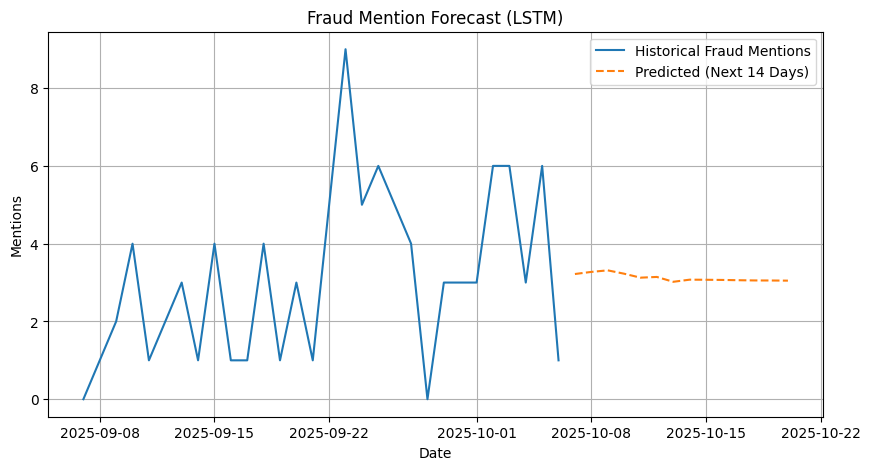

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load cleaned review file
df = pd.read_csv("cleaned_app_reviews.csv")
df["date"] = pd.to_datetime(df["at"]).dt.date

# 1.  Daily fraud count
fraud_ts = df[df["issue_type"] == "Fraud"].groupby("date").size()
fraud_ts = fraud_ts.asfreq("D").fillna(0)  # fill missing dates with 0

# 2.  Train/Test Split
scaler = MinMaxScaler()
scaled = scaler.fit_transform(fraud_ts.values.reshape(-1, 1))

def create_sequences(data, window=7):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, window=7)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 3.  LSTM Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(7,1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, verbose=0)

# 4.  Predict Next 14 Days
pred_input = scaled[-7:].reshape((1, 7, 1))
preds = []
for _ in range(14):
    pred = model.predict(pred_input)[0]
    preds.append(pred)
    pred_input = np.append(pred_input[:,1:,:], [[pred]], axis=1)

# 5.  Plot
future_dates = pd.date_range(fraud_ts.index[-1] + timedelta(days=1), periods=14)
predicted_values = scaler.inverse_transform(preds)

plt.figure(figsize=(10,5))
plt.plot(fraud_ts[-30:], label="Historical Fraud Mentions")
plt.plot(future_dates, predicted_values, label="Predicted (Next 14 Days)", linestyle="--")
plt.title("Fraud Mention Forecast (LSTM)")
plt.xlabel("Date")
plt.ylabel("Mentions")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install -q tensorflow matplotlib scikit-learn pandas


In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_app_reviews.csv")
df["date"] = pd.to_datetime(df["at"]).dt.date  
df.head()


reviewId             userName  \
0  a5a7c4ed-45b5-4e68-a5ff-f4d2c4595556          mr superman   
1  3f39498f-d67e-44a5-a307-549578a110b5  Tshegofatso Thetele   
2  7e5fdf0b-59ca-490b-a4e0-6a7594c63d8a           saraf khan   
3  07b8c844-27e7-4fc4-9f93-0b137c63a6a6           Mark White   
4  96d4c712-7be9-4eb8-a8f2-820341489649          Oshay Blake   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  unfortunately it won't let me screenshot for p...      1              0   
1                           best app and safe to use      5              0   
2            PayPal hold my money. I can't recommend      1              0   
3  lost all money I earned by being permanently d...      1              0   
4  paypal is an wonderful app makes work much eas...      5              0   

  reviewCreatedVersion                   at replyContent repliedAt appVersion  \
0               8.93.1  2025-10-06 16:19:17          NaN       NaN     8.93.1   
1               8.93.1  2025-10-06 16:14:19          NaN       NaN     8.93.1   
2               8.93.1  2025-10-06 15:05:24          NaN       NaN     8.93.1   
3               8.93.1  2025-10-06 14:47:00          NaN       NaN     8.93.1   
4               8.93.1  2025-10-06 14:39:28          NaN       NaN     8.93.1   

  app_name                                    cleaned_content  review_length  \
0   PayPal  unfortunately it wont let me screenshot for pr...             57   
1   PayPal                           best app and safe to use             24   
2   PayPal             PayPal hold my money. I cant recommend             38   
3   PayPal  lost all money I earned by being permanently d...            408   
4   PayPal  paypal is an wonderful app makes work much eas...             72   

  issue_type  is_fake        date  
0   Positive    False  2025-10-06  
1   Positive    False  2025-10-06  
2   Positive    False  2025-10-06  
3   Positive    False  2025-10-06  
4   Positive    False  2025-10-06

In [ ]:
!pip install tensorflow --quiet


In [ ]:
# STEP 2: Load CSV and prepare recent reviews
import pandas as pd
from datetime import datetime, timedelta

df = pd.read_csv("cleaned_app_reviews.csv")
df["date"] = pd.to_datetime(df["at"]).dt.date

cutoff = datetime.now().date() - timedelta(days=180)
recent_df = df[df["date"] >= cutoff]


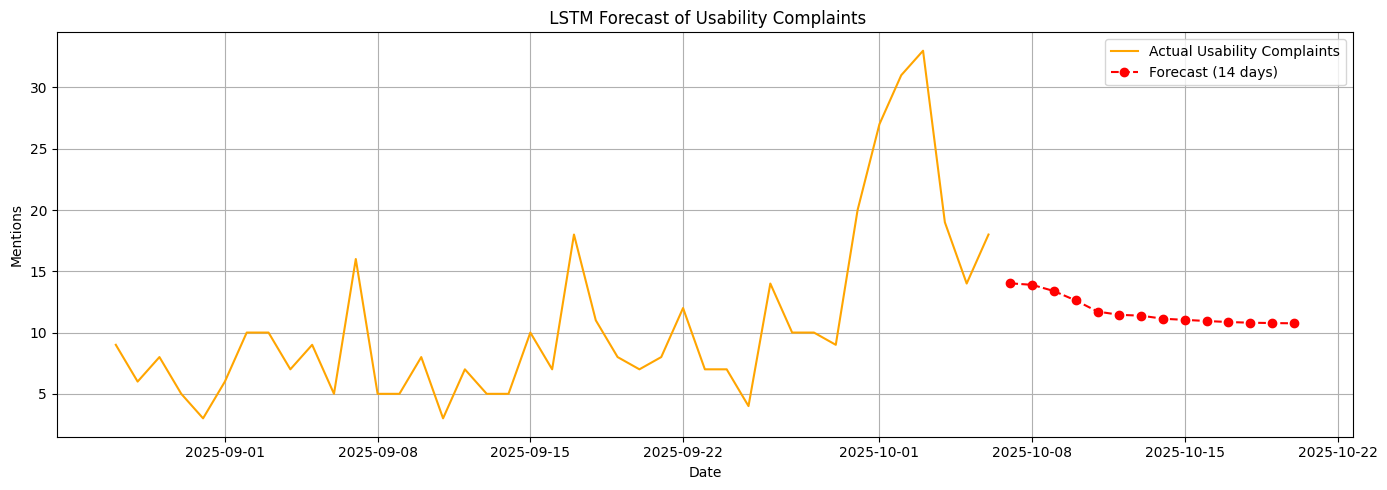

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. Load cleaned dataset
df = pd.read_csv("cleaned_app_reviews.csv")
df["date"] = pd.to_datetime(df["at"]).dt.date

# 2. Filter usability complaints
usability_ts = df[df["issue_type"] == "Usability"].groupby("date").size().rename("usability_count")
usability_ts = usability_ts.asfreq('D').fillna(0)

# 3. Scale for LSTM
scaler = MinMaxScaler()
scaled = scaler.fit_transform(usability_ts.values.reshape(-1, 1))

# 4. Create 7-day sequences
def create_sequences(data, window=7):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

if len(scaled) >= 8:
    X, y = create_sequences(scaled)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # 5. Build LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, verbose=0)

    # 6. Predict next 14 days
    input_seq = scaled[-7:].reshape((1, 7, 1))
    preds = []
    for _ in range(14):
        next_val = model.predict(input_seq, verbose=0)[0][0]
        preds.append(next_val)
        input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)

    # 7. Inverse scale + dates
    forecast_values = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    forecast_dates = pd.date_range(start=usability_ts.index[-1] + timedelta(days=1), periods=14)
    forecast_series = pd.Series(forecast_values, index=forecast_dates)

    # 8. Plot
    plt.figure(figsize=(14, 5))
    plt.plot(usability_ts[-60:], label="Actual Usability Complaints", color="orange")
    plt.plot(forecast_series, label="Forecast (14 days)", color="red", linestyle="--", marker='o')
    plt.title(" LSTM Forecast of Usability Complaints")
    plt.xlabel("Date")
    plt.ylabel("Mentions")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 9. Optional: save forecast
    forecast_series.to_csv("usability_forecast.csv")
else:
    print("Not enough data to train LSTM on usability issues.")


In [ ]:
# Save fraud forecast data (from your LSTM fraud model step)
forecast_series.to_csv("fraud_forecast.csv")


# Save usability forecast data (from your LSTM usability model step)
forecast_series.to_csv("usability_forecast.csv")


In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_app_reviews.csv")
print(df.head())


                               reviewId             userName  \
0  a5a7c4ed-45b5-4e68-a5ff-f4d2c4595556          mr superman   
1  3f39498f-d67e-44a5-a307-549578a110b5  Tshegofatso Thetele   
2  7e5fdf0b-59ca-490b-a4e0-6a7594c63d8a           saraf khan   
3  07b8c844-27e7-4fc4-9f93-0b137c63a6a6           Mark White   
4  96d4c712-7be9-4eb8-a8f2-820341489649          Oshay Blake   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  unfortunately it won't let me screenshot for p...      1              0   
1                           best app and safe to use      5              0   
2            PayPal hold my money. I can't r

In [ ]:
usability_df = df[df["issue_type"] == "Usability"]
fraud_df = df[df["issue_type"] == "Fraud"]

usability_df.to_csv("usability_forecast.csv", index=False)
fraud_df.to_csv("fraud_forecast.csv", index=False)

print("Files saved: usability_forecast.csv and fraud_forecast.csv")


Files saved: usability_forecast.csv and fraud_forecast.csv


In [ ]:
import pandas as pd

df = pd.read_csv("fraud_forecast.csv")
print(df.head())

                               reviewId          userName  \
0  ba8de059-18a3-48c6-96d4-f47fe7aefc45   Tshifhiwa Mudau   
1  1d6dcbf0-f6a4-477e-9fca-4b90cfcaa281      Ronnie Bolen   
2  d546928b-01fb-43e5-9d43-cc80597ee6fd  thaddeus pittman   
3  19a3bc18-81b3-4bcd-936f-38523d43e764         Jerry Lee   
4  67fec3c4-4f7a-446f-b46e-196a67ed1ecf     Darla Hampton   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a/ACg8oc...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  I used PayPal was hacked since then when I try...      1              0   
1  sucks now used be the bees knees now it's noth...      1              0   
2          too much fraud way ,!!too 2 much fraud!!!      1   

In [ ]:
import pandas as pd

df = pd.read_csv("usability_forecast.csv")
print(df.head())


                               reviewId          userName  \
0  d171d7f3-25c7-4c43-8b01-d783821d4cad       ERIC MOGENT   
1  fee31bf6-4af1-4d14-a4d0-624de96f5ea9      Kelly Graham   
2  f1bb1e55-70eb-4c09-8768-465f3d0d8694  Gerald Chennault   
3  5a7a3d73-6e1a-4235-a13b-c206f4fc5588        Josh Smith   
4  67199d9b-3deb-45f8-bcbb-6140497b159a     Ellis Saladin   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a/ACg8oc...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  I don't know what is going on with this app. I...      2              9   
1  they blocked me cause I'm old a ND couldn't fi...      1              0   
2      Quick and reliable very professional and frie      5   

 Complaint Summary per App:


issue_type  Fraud  Usability  Total  Fraud %  Usability %   Dominant
app_name                                                            
GPay           17         99    116    14.66        85.34  Usability
PayPal         92        261    353    26.06        73.94  Usability
PhonePe         8         76     84     9.52        90.48  Usability

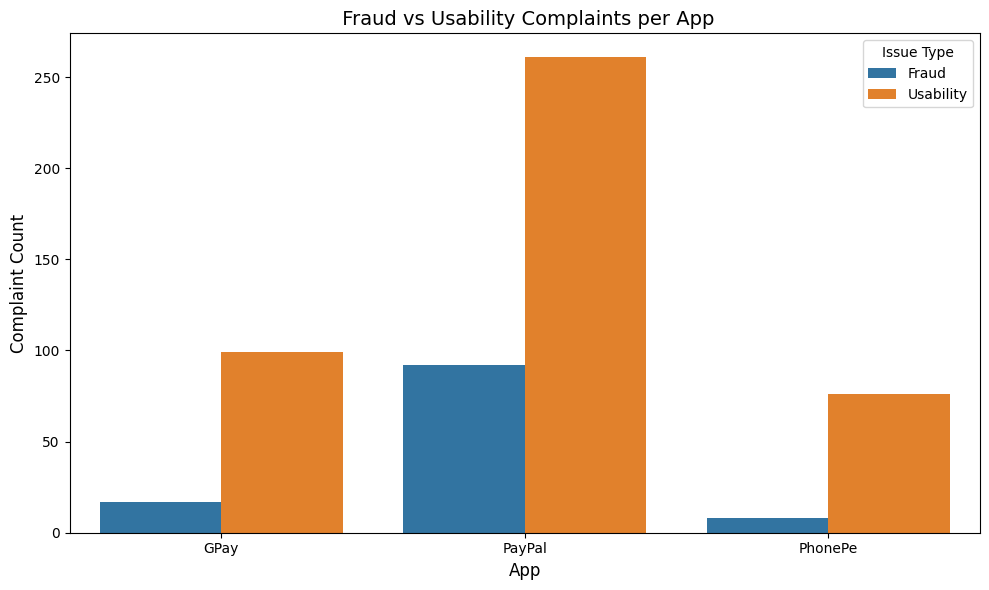

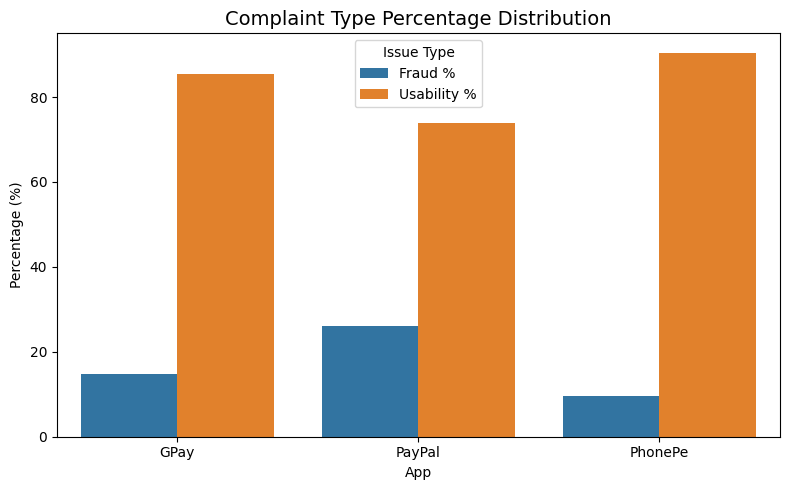


 Dominant Complaint Type per App:


issue_type app_name  Fraud %  Usability %   Dominant
0              GPay    14.66        85.34  Usability
1            PayPal    26.06        73.94  Usability
2           PhonePe     9.52        90.48  Usability

Summary exported: app_complaint_summary.csv


In [ ]:
# =====================================================
#  APP COMPLAINT DASHBOARD — FRAUD VS USABILITY (COLAB)
# =====================================================

# --- Setup ---
!pip install pandas matplotlib seaborn plotly --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# --- Load data ---
reviews_df = pd.read_csv("cleaned_app_reviews.csv")
usability_df = pd.read_csv("usability_forecast.csv")
fraud_df = pd.read_csv("fraud_forecast.csv")

# --- Normalize column names ---
for df in [reviews_df, usability_df, fraud_df]:
    df.columns = [c.strip().lower() for c in df.columns]

# --- Parse date columns (if present) ---
for df in [reviews_df, usability_df, fraud_df]:
    if "at" in df.columns:
        df["at"] = pd.to_datetime(df["at"], errors="coerce")

# --- Label datasets for merging ---
usability_df["issue_type"] = "Usability"
fraud_df["issue_type"] = "Fraud"

# --- Combine all issues ---
combined_df = pd.concat([usability_df, fraud_df], ignore_index=True)

# --- Generate summary per app ---
summary = (
    combined_df.groupby(["app_name", "issue_type"])
    .size()
    .reset_index(name="count")
)

# --- Pivot into wide format ---
summary_pivot = summary.pivot(index="app_name", columns="issue_type", values="count").fillna(0)

# --- Flatten columns in case of MultiIndex ---
summary_pivot.columns = summary_pivot.columns.get_level_values(-1)

# --- Compute totals and percentages ---
summary_pivot["Total"] = summary_pivot["Fraud"] + summary_pivot["Usability"]
summary_pivot["Fraud %"] = (summary_pivot["Fraud"] / summary_pivot["Total"] * 100).round(2)
summary_pivot["Usability %"] = (summary_pivot["Usability"] / summary_pivot["Total"] * 100).round(2)
summary_pivot["Dominant"] = summary_pivot.apply(
    lambda row: "Fraud" if row["Fraud"] > row["Usability"] else "Usability", axis=1
)

print(" Complaint Summary per App:")
display(summary_pivot)

# =====================================================
# 1. Bar Chart — Fraud vs Usability Complaints per App
# =====================================================
plt.figure(figsize=(10, 6))
summary_melt = summary_pivot.reset_index()[["app_name", "Fraud", "Usability"]].melt(
    id_vars="app_name", var_name="Issue Type", value_name="Count"
)
sns.barplot(data=summary_melt, x="app_name", y="Count", hue="Issue Type")
plt.title(" Fraud vs Usability Complaints per App", fontsize=14)
plt.xlabel("App", fontsize=12)
plt.ylabel("Complaint Count", fontsize=12)
plt.legend(title="Issue Type")
plt.tight_layout()
plt.show()

# =====================================================
# 2. Percentage Distribution Chart
# =====================================================
plt.figure(figsize=(8, 5))
summary_pct = summary_pivot.reset_index()[["app_name", "Fraud %", "Usability %"]].melt(
    id_vars="app_name", var_name="Issue Type", value_name="Percentage"
)
sns.barplot(data=summary_pct, x="app_name", y="Percentage", hue="Issue Type")
plt.title("Complaint Type Percentage Distribution", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xlabel("App")
plt.legend(title="Issue Type")
plt.tight_layout()
plt.show()

# =====================================================
# 3. Time Series Trend — Weekly Trends by App
# =====================================================

if "at" in combined_df.columns:
    # --- Aggregate weekly counts ---
    ts = (
        combined_df.groupby([pd.Grouper(key="at", freq="W"), "issue_type", "app_name"])
        .size()
        .reset_index(name="count")
    )

    # --- Assign unique colors for better separation ---
    issue_colors = {
        "Fraud": "#E74C3C",      # red
        "Usability": "#3498DB"   # blue
    }

    app_colors = {
        "PayPal": "#1ABC9C",
        "GPay": "#9B59B6",
        "PhonePe": "#F39C12"
    }

    # --- Plotly interactive line chart ---
    fig = px.line(
        ts,
        x="at",
        y="count",
        color="issue_type",
        facet_col="app_name",
        title=" Weekly Trends: Fraud vs Usability Complaints per App",
        markers=True,
        color_discrete_map=issue_colors
    )

    # --- Customize layout ---
    fig.update_traces(line=dict(width=3))
    fig.update_layout(
        template="plotly_white",
        height=600,
        font=dict(size=13),
        plot_bgcolor="rgba(0,0,0,0)",
        legend_title_text="Issue Type",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )

    # --- Add background grid & hover styling ---
    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor="lightgrey")
    fig.update_traces(
        hovertemplate="<b>%{x|%b %d, %Y}</b><br>App: %{facet_col}<br>%{y} complaints<br>Type: %{legendgroup}"
    )

    fig.show()

else:
    print(" No 'at' (date) column found — skipping time series plot.")


# =====================================================
# 4. Dominance Table — Which Issue Type Dominates
# =====================================================
dominance = summary_pivot[["Fraud %", "Usability %", "Dominant"]].reset_index()
print("\n Dominant Complaint Type per App:")
display(dominance)

# =====================================================
# Save Results
# =====================================================
summary_pivot.to_csv("app_complaint_summary.csv")
print("Summary exported: app_complaint_summary.csv")


In [5]:
import pandas as pd

df = pd.read_csv("cleaned_app_reviews.csv")
print(df.head())

                               reviewId             userName  \
0  a5a7c4ed-45b5-4e68-a5ff-f4d2c4595556          mr superman   
1  3f39498f-d67e-44a5-a307-549578a110b5  Tshegofatso Thetele   
2  7e5fdf0b-59ca-490b-a4e0-6a7594c63d8a           saraf khan   
3  07b8c844-27e7-4fc4-9f93-0b137c63a6a6           Mark White   
4  96d4c712-7be9-4eb8-a8f2-820341489649          Oshay Blake   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  unfortunately it won't let me screenshot for p...      1              0   
1                           best app and safe to use      5              0   
2            PayPal hold my money. I can't r

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
 Classification Report:
              precision    recall  f1-score   support

    Positive       0.95      1.00      0.97      4998
       Fraud       1.00      0.30      0.46       117
   Usability       1.00      0.55      0.71       436

    accuracy                           0.95      5551
   macro avg       0.98      0.62      0.71      5551
weighted avg       0.95      0.95      0.94      5551



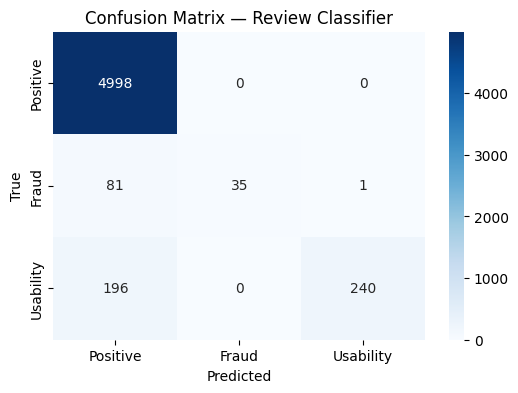

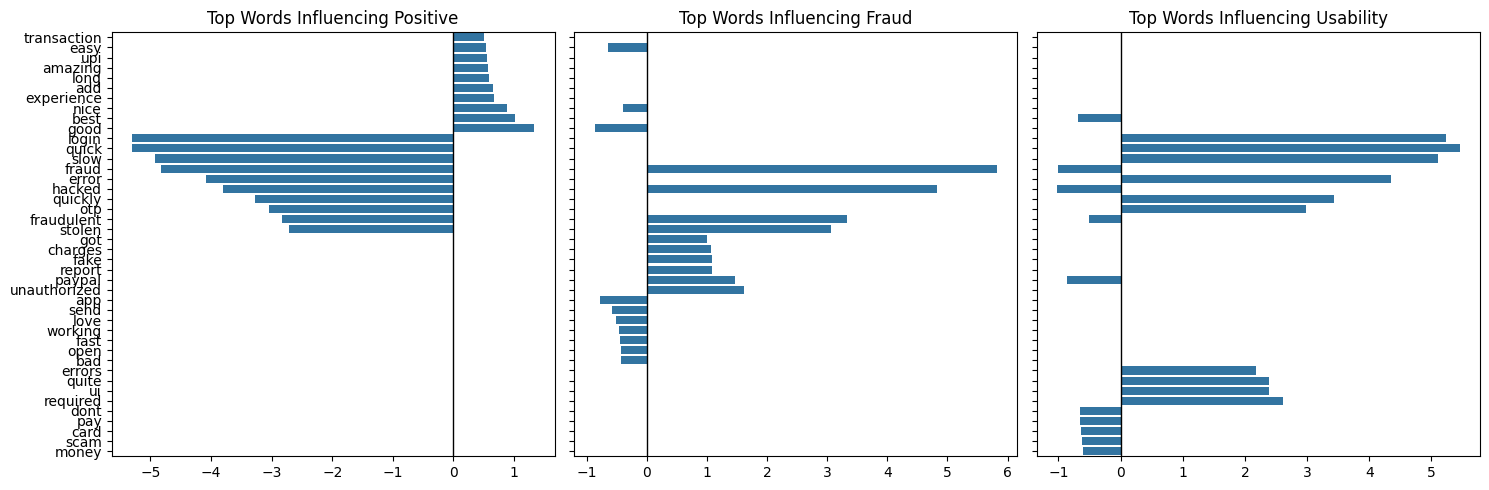


 === PAYPAL ===

 Review (Positive):
Glad I Have Use PayPal! Saved me from Another Bad Experience with an AUTOpay that Wasnt playing nice!

 Key word influences:
  • nice                      → weight: -0.005
  • PayPal                    → weight: 0.005
  • Wasnt                     → weight: 0.004
  • Experience                → weight: -0.004
  • Bad                       → weight: -0.002
  • AUTOpay                   → weight: -0.001


None


 === GPAY ===

 Review (Positive):
very nice and easy to use. thanks

 Key word influences:
  • nice                      → weight: -0.003
  • easy                      → weight: -0.002
  • use                       → weight: 0.000
  • thanks                    → weight: -0.000
  • to                        → weight: -0.000
  • and                       → weight: -0.000


None


 === PHONEPE ===

 Review (Positive):
lt is faster and a safe app. l use the app from the covid period. lt is easy to use. My experience is enough satisfactory.

 Key word influences:
  • app                       → weight: -0.002
  • lt                        → weight: 0.001
  • easy                      → weight: -0.001
  • experience                → weight: -0.001
  • safe                      → weight: 0.000
  • faster                    → weight: -0.000


None

In [6]:
# ====================================================
#  EXPLAINABLE AI — APP REVIEW CLASSIFIER (LIME + TF-IDF)
# ====================================================

!pip install lime scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import lime
import lime.lime_text

# --- Load dataset ---
df = pd.read_csv("cleaned_app_reviews.csv")

# Ensure text column exists
if "cleaned_content" not in df.columns:
    df["cleaned_content"] = df["content"]

# Keep only relevant columns
df = df[["app_name", "cleaned_content", "issue_type"]].dropna()

# --- Label encoding ---
label_map = {"Positive": 0, "Fraud": 1, "Usability": 2}
df = df[df["issue_type"].isin(label_map.keys())]
df["label"] = df["issue_type"].map(label_map)

# --- TF-IDF + Logistic Regression ---
vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X = vectorizer.fit_transform(df["cleaned_content"])
y = df["label"]

clf = LogisticRegression(max_iter=500)
clf.fit(X, y)

# --- Evaluation ---
y_pred = clf.predict(X)
print(" Classification Report:")
print(classification_report(y, y_pred, target_names=["Positive", "Fraud", "Usability"]))

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Positive","Fraud","Usability"],
            yticklabels=["Positive","Fraud","Usability"])
plt.title("Confusion Matrix — Review Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- GLOBAL FEATURE IMPORTANCE (most influential words overall) ---
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_

fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
classes = ["Positive", "Fraud", "Usability"]

for i, ax in enumerate(axes):
    top_idx = np.argsort(coefs[i])[-10:]
    bottom_idx = np.argsort(coefs[i])[:10]
    words = np.concatenate([feature_names[top_idx], feature_names[bottom_idx]])
    weights = np.concatenate([coefs[i][top_idx], coefs[i][bottom_idx]])
    sns.barplot(x=weights, y=words, ax=ax)
    ax.set_title(f"Top Words Influencing {classes[i]}")
    ax.axvline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()

# --- Build LIME Explainer ---
pipeline = make_pipeline(vectorizer, clf)
explainer = lime.lime_text.LimeTextExplainer(class_names=classes)

# --- LOCAL EXPLANATION: Explain a few reviews per app ---
for app in df["app_name"].unique():
    print(f"\n === {app.upper()} ===")
    app_subset = df[df["app_name"] == app].sample(1, random_state=42)
    for _, row in app_subset.iterrows():
        review = row["cleaned_content"]
        true_label = row["issue_type"]
        print(f"\n Review ({true_label}):\n{review}\n")

        exp = explainer.explain_instance(
            review,
            pipeline.predict_proba,
            num_features=6
        )

        print(" Key word influences:")
        for feature, weight in exp.as_list():
            print(f"  • {feature:25} → weight: {weight:.3f}")

        # Inline visualization (interactive in Colab)
        display(exp.show_in_notebook(text=True))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/tmp/ipython-input-2587745026.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=ax, palette="deep")
/tmp/ipython-input-2587745026.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=ax, palette="deep")
/tmp/ipython-input-2587745026.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` vari

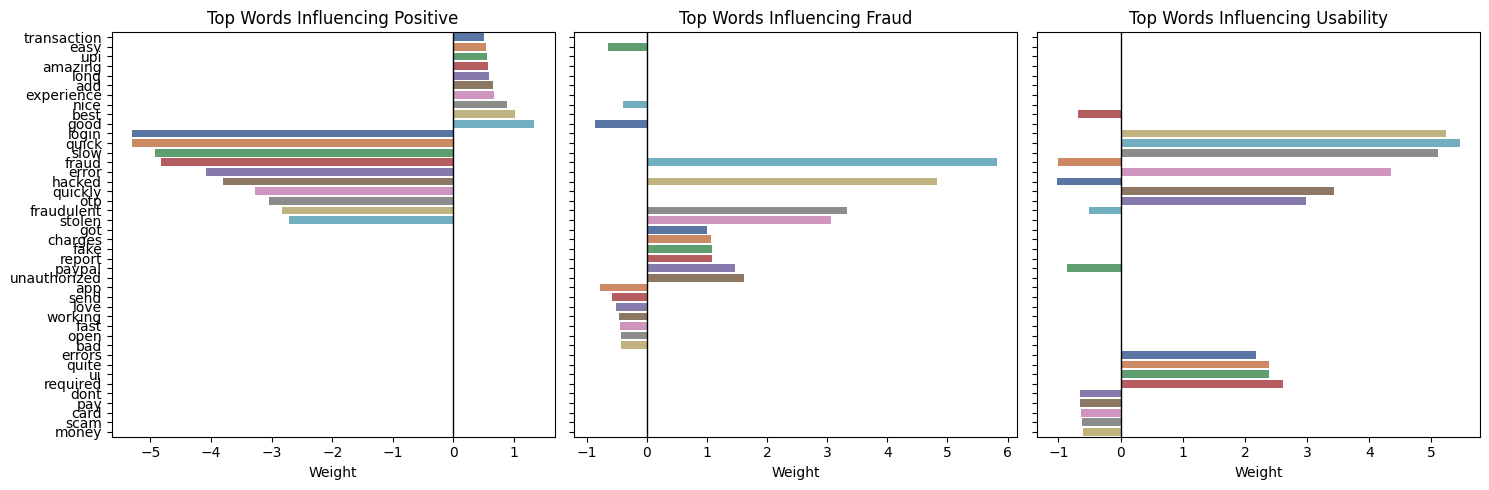

Global_Feature_Importance.pdf exported successfully.


In [8]:
# =====================================================
#  Global Feature Importance by Complaint Category
# =====================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# --- Load dataset ---
df = pd.read_csv("cleaned_app_reviews.csv")

# Ensure text column exists
if "cleaned_content" not in df.columns:
    df["cleaned_content"] = df["content"]

df = df[["cleaned_content", "issue_type"]].dropna()

# --- Encode labels ---
label_map = {"Positive": 0, "Fraud": 1, "Usability": 2}
df = df[df["issue_type"].isin(label_map.keys())]
df["label"] = df["issue_type"].map(label_map)

# --- TF-IDF + Logistic Regression ---
vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X = vectorizer.fit_transform(df["cleaned_content"])
y = df["label"]

clf = LogisticRegression(max_iter=500, solver="lbfgs", multi_class="auto")
clf.fit(X, y)

# --- Global feature importance ---
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_
classes = ["Positive", "Fraud", "Usability"]

# --- Plot top/bottom features for each class ---
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for i, ax in enumerate(axes):
    top_idx = np.argsort(coefs[i])[-10:]
    bottom_idx = np.argsort(coefs[i])[:10]
    words = np.concatenate([feature_names[top_idx], feature_names[bottom_idx]])
    weights = np.concatenate([coefs[i][top_idx], coefs[i][bottom_idx]])
    sns.barplot(x=weights, y=words, ax=ax, palette="deep")
    ax.set_title(f"Top Words Influencing {classes[i]}", fontsize=12)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("Weight")
    ax.set_ylabel("")

plt.tight_layout()
plt.savefig("Global_Feature_Importance.pdf", bbox_inches="tight")
plt.show()

print("Global_Feature_Importance.pdf exported successfully.")


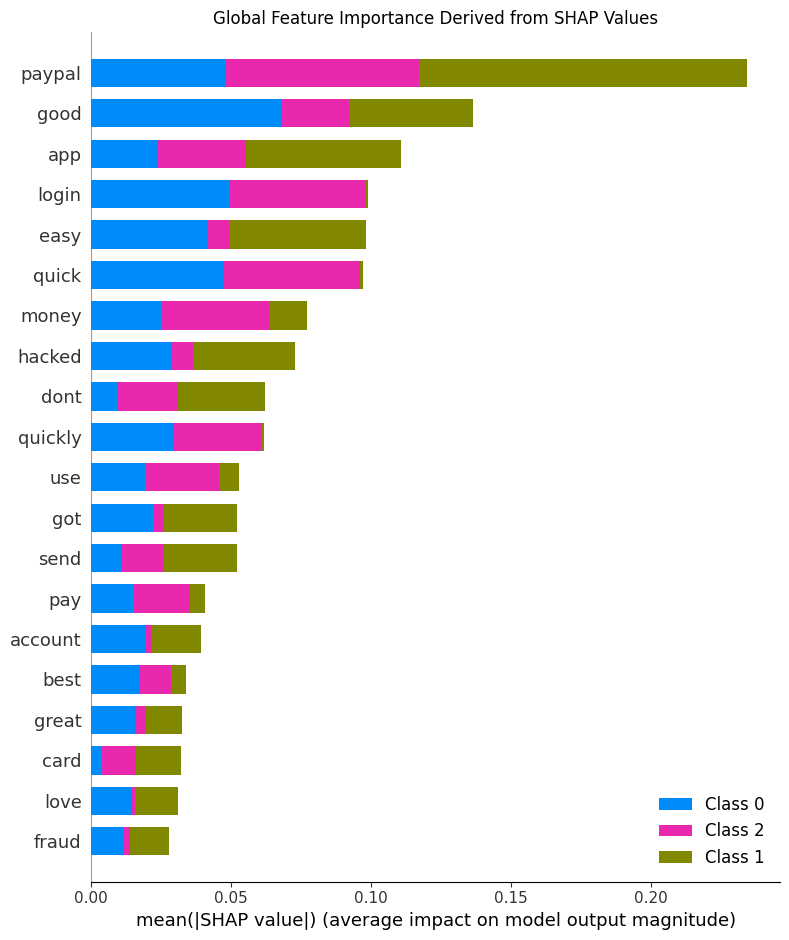

Global_SHAP_Importance.pdf exported successfully.


In [9]:
# =====================================================
# Global SHAP Feature Importance
# =====================================================

import shap
import matplotlib.pyplot as plt
import numpy as np

# Ensure vectorizer and clf are trained from earlier steps
X_sample = X[:500]  # subset for speed

# Build SHAP explainer for logistic regression
shap_explainer = shap.Explainer(clf, X_sample, feature_names=vectorizer.get_feature_names_out())
shap_values = shap_explainer(X_sample)

# --- SHAP Summary Plot ---
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, feature_names=vectorizer.get_feature_names_out(), show=False)
plt.title("Global Feature Importance Derived from SHAP Values", fontsize=12)
plt.tight_layout()

plt.savefig("Global_SHAP_Importance.pdf", bbox_inches="tight")
plt.show()

print("Global_SHAP_Importance.pdf exported successfully.")


2025-10-07 16:30:35.138 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 16:30:35.139 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 16:30:35.637 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-07 16:30:35.640 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 16:30:35.641 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 16:30:35.646 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-07 16:30:35.649 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

<Figure size 1200x500 with 0 Axes>

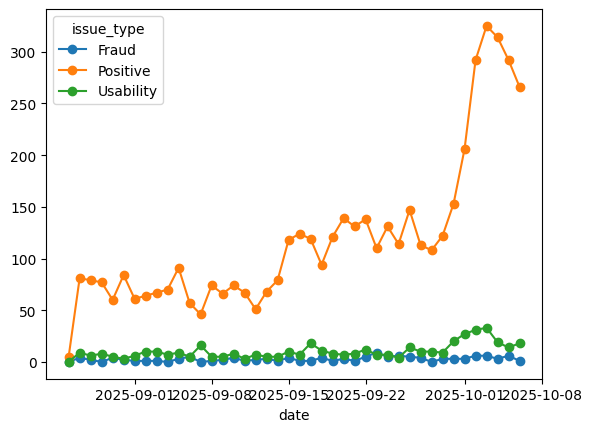

In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

st.set_page_config(page_title="Review Forecast Dashboard", layout="wide")

st.title("App Review Forecast Dashboard")
st.markdown("Real-time monitoring of **fraud** and **usability** complaints using AI")

# Load data
df = pd.read_csv("cleaned_app_reviews.csv", parse_dates=["at"])
df["date"] = df["at"].dt.date

fraud_forecast = pd.read_csv("fraud_forecast.csv", index_col=0, parse_dates=True)
usability_forecast = pd.read_csv("usability_forecast.csv", index_col=0, parse_dates=True)

# Daily counts
daily = df.groupby(["date", "issue_type"]).size().unstack().fillna(0)

st.subheader("Daily Issue Trends (Past 60 Days)")
plt.figure(figsize=(12,5))
daily[-60:].plot(kind="line", marker='o')
st.pyplot(plt)


# Expandable raw review browser
st.markdown("### Browse Reviews")
with st.expander("View Raw Review Data"):
    st.dataframe(df[["date", "content", "issue_type", "score"]].sort_values("date", ascending=False).head(200))
